## Model Training

### 1.1 Import Packages and Data

In [77]:
# Basic Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer, confusion_matrix, roc_curve, precision_recall_curve
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from sklearn.utils.class_weight import compute_class_weight

# FEature Importance
import shap


# Preprocessing
from sklearn.preprocessing import RobustScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from scipy.stats import boxcox
from sklearn.pipeline import Pipeline

# Error handling
import warnings
warnings.filterwarnings("ignore")

### Import the CSV Data as Pandas DataFrame

In [2]:
df = pd.read_csv('data/customer_churn.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Call Failure             3150 non-null   int64  
 1   Complaints               3150 non-null   int64  
 2   Subscription Length      3150 non-null   int64  
 3   Charge Amount            3150 non-null   int64  
 4   Seconds of Use           3150 non-null   int64  
 5   Frequency of use         3150 non-null   int64  
 6   Frequency of SMS         3150 non-null   int64  
 7   Distinct Called Numbers  3150 non-null   int64  
 8   Age Group                3150 non-null   int64  
 9   Tariff Plan              3150 non-null   int64  
 10  Status                   3150 non-null   int64  
 11  Age                      3150 non-null   int64  
 12  Customer Value           3150 non-null   float64
 13  Churn                    3150 non-null   int64  
dtypes: float64(1), int64(13)

### Drop Duplicate

In [4]:
df.drop_duplicates(inplace=True)  # Remove duplicate rows

### Preparing X and Y variables

In [5]:
X = df.drop(columns=['Churn']).copy()

In [6]:
X.head()

,Call Failure,Complaints,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805


In [7]:
df.columns

Index(['Call Failure', 'Complaints', 'Subscription Length', 'Charge Amount',
       'Seconds of Use', 'Frequency of use', 'Frequency of SMS',
       'Distinct Called Numbers', 'Age Group', 'Tariff Plan', 'Status', 'Age',
       'Customer Value', 'Churn'],
      dtype='object')

In [8]:
y = df['Churn']
y

0       0
1       0
2       0
3       0
4       0
       ..
3096    0
3097    0
3099    1
3123    0
3131    1
Name: Churn, Length: 2850, dtype: int64

### Preprocessing

I used Robust scalar because of the presence of outliers in the orginal datasets.


In [81]:
# Define feature groups
binary_columns = ['Tariff Plan', 'Status', 'Complaints']
ordinal_columns = ['Age Group', 'Charge Amount']
log_transform_columns = ['Call Failure', 'Frequency of use', 'Frequency of SMS', 'Age']  # Columns for log transform
boxcox_transform_columns = ['Seconds of Use', 'Distinct Called Numbers', 'Customer Value']  # Columns for Box-Cox
reflect_transform_columns = ['Subscription Length']  # Columns for reflection transform


In [10]:
# Drop target variable
#X = df.drop(columns=['Churn']).copy()

In [82]:
#  fixed transformation functions 

# Custom binary transformation function
def binary_change(x):
    """Convert 1 to 0 and 2 to 1 for binary columns that need it."""
    return np.where(x == 2, 1, np.where(x == 1, 0, x))

# Custom function to apply binary_change only to specific columns
def selective_binary_transform(X, columns_to_transform):
    """Apply binary_change only to specified columns."""
    X_transformed = X.copy()
    for i, col in enumerate(binary_columns):
        if col in columns_to_transform:
            X_transformed[:, i] = binary_change(X_transformed[:, i])
    return X_transformed

def boxcox_transform(x):
    """Apply Box-Cox transformation ensuring positive values"""
    x = np.clip(x, 1e-6, None)  # Ensure values are positive (>0)
    return np.column_stack([boxcox(x[:, i])[0] for i in range(x.shape[1])])

def reflect_transform(x):
    """Apply reflection transformation to 'Subscription Length'"""
    return np.max(x, axis=0) - x

def compute_call_efficiency(X):
    """Compute Call Efficiency = Seconds of Use / Frequency of Use"""
    return (X[:, 0] / np.clip(X[:, 1], 1e-6, None)).reshape(-1, 1)  # Avoid division by zero

In [83]:
# Preprocessor
preprocessor = ColumnTransformer([
    # Binary columns: Impute missing values and apply selective binary transformation
    ('bin', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('selective_binary', FunctionTransformer(
            lambda X: selective_binary_transform(X, columns_to_transform=['Tariff Plan', 'Status']),
            validate=False
        ))
    ]), binary_columns),

    # Ordinal columns: Impute and scale
    ('ord', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', RobustScaler())
    ]), ordinal_columns),

    # Compute 'Call Efficiency', log-transform, and scale
    ('call_efficiency', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('call_eff', FunctionTransformer(compute_call_efficiency, validate=False)),
        ('log', FunctionTransformer(np.log1p, validate=False)),
        ('scaler', RobustScaler())
    ]), ['Seconds of Use', 'Frequency of use']),

    # Log transform specific columns
    ('log', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('log_transform', FunctionTransformer(np.log1p, validate=False)),
        ('scaler', RobustScaler())
    ]), log_transform_columns),

    # Box-Cox transform specific columns
    ('boxcox', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('boxcox_transform', FunctionTransformer(boxcox_transform, validate=False)),
        ('scaler', RobustScaler())
    ]), boxcox_transform_columns),

    # Reflect and log transform Subscription Length
    ('reflect', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('reflect_transform', FunctionTransformer(reflect_transform, validate=False)),
        ('log_transform', FunctionTransformer(np.log1p, validate=False)),
        ('scaler', RobustScaler())
    ]), reflect_transform_columns),
])

In [84]:
# Apply Transformation

X_transformed = preprocessor.fit_transform(X)



In [85]:
X_transformed.shape

(2850, 14)

*Based off Preprocessing steps these are the columns in order*

In [96]:
transformed_feature_names = [
    'Tariff Plan', 'Status', 'Complaints',  # Binary columns
    'Age Group', 'Charge Amount',  # Ordinal columns
    'Call Efficiency',  # Computed feature
    'Call Failure', 'Frequency of use', 'Frequency of SMS', 'Age',  # Log transform columns
    'Seconds of Use', 'Distinct Called Numbers', 'Customer Value',  # Box-Cox transform columns
    'Subscription Length'  # Reflect transform columns
]

### Split Data into Test and Train

The distribution of "churned" vs. "not churned" is uneven, the default split (train_test_split) will likely result in an even further imbalance in the training and testing datasets. This could lead to poor model performance, especially for the underrepresented class.

The best approach would be to stratify the split, which ensures that the proportion of each class in the target variable (Churn) is maintained in both the training and testing datasets.

In [86]:
# Stratified split to maintain the same proportion(distribution) of each class
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42, stratify=y)


# Check the distribution of Churn in both training and test sets
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

Churn
0    0.843421
1    0.156579
Name: proportion, dtype: float64
Churn
0    0.84386
1    0.15614
Name: proportion, dtype: float64


### Evaluation Metric Function

In [87]:
# Function to evaluate models using classification metrics
def evaluate_classification_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    return accuracy, precision, recall, f1, auc

since the  dataset is small (2850 rows, 14 features) and imbalanced (15.6% churn customers), I'd be adjusting class weights in the model instead of resampling.

*Compute Class Weights*

In [88]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weight_dict = {cls: weight for cls, weight in zip(np.unique(y), class_weights)}

# Compute scale_pos_weight for CatBoost
scale_pos_weight = class_weight_dict[0] / class_weight_dict[1]  # Adjust based on class 0 & 1 ratio

In [89]:
# Define models with class weights where applicable
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', random_state=42),
    "Random Forest Classifier": RandomForestClassifier(class_weight='balanced', random_state=42),
    "CatBoosting Classifier": CatBoostClassifier(scale_pos_weight=scale_pos_weight, verbose=0, random_seed=42),
    "SVC": SVC(class_weight='balanced', probability=True, random_state=42),
}

In [90]:
# Define hyperparameter grids for RandomizedSearchCV (to be customized)
param_grids = {
    "Logistic Regression": {
        'C': [0.01, 0.1, 1, 10],               # Regularization strength
        'solver': ['liblinear', 'lbfgs'],       # Optimization algorithms
        'max_iter': [100, 200, 300]             # Maximum iterations for convergence
    },
    "Random Forest Classifier": {
        'n_estimators': [50, 100, 200, 500],    # Number of trees
        'max_depth': [None, 10, 20, 30],         # Depth of trees
        'min_samples_split': [2, 5, 10],         # Minimum samples to split a node
        'min_samples_leaf': [1, 2, 4],           # Minimum samples at leaf node
        'max_features': ['auto', 'sqrt', 'log2'] # Maximum features to consider at split
    },
    "CatBoosting Classifier": {
        'iterations': [100, 200, 300],           # Number of boosting iterations
        'learning_rate': [0.01, 0.05, 0.1],      # Step size for each boosting round
        'depth': [4, 6, 8],                       # Depth of trees
        'l2_leaf_reg': [1, 3, 5],                 # L2 regularization coefficient
        'subsample': [0.6, 0.8, 1]                # Fraction of samples used for fitting each tree
    },
    "SVC": {
        'C': [0.1, 1, 10, 100],                   # Regularization parameter
        'kernel': ['linear', 'rbf'],              # Kernel type
        'gamma': ['scale', 'auto'],               # Kernel coefficient
        'degree': [3, 4, 5]                       # Degree of the polynomial kernel
    },
   
}

In [91]:
# Lists to store results
model_list = []
auc_list = []

# Dictionary to store the best parameters for each model
best_params = {}

In [92]:
# Iterate through models
for model_name, model in models.items():
    print(f"Training {model_name}...")

    # Hyperparameter tuning using RandomizedSearchCV if a param_grid is defined
    if model_name in param_grids:
        print("Performing RandomizedSearchCV...")
        search = RandomizedSearchCV(model, param_distributions=param_grids[model_name],
                                    n_iter=10, random_state=42, n_jobs=-1, cv=3)
        search.fit(X_train, y_train)
        model = search.best_estimator_

        # Save the best parameters
        best_params[model_name] = search.best_params_

    # Train model
    model.fit(X_train, y_train)

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Evaluate Train and Test dataset
    model_train_accuracy, model_train_precision, model_train_recall, model_train_f1, model_train_auc = evaluate_classification_model(y_train, y_train_pred)
    model_test_accuracy, model_test_precision, model_test_recall, model_test_f1, model_test_auc = evaluate_classification_model(y_test, y_test_pred)

    # Output model results
    print(f"Model performance for Training set - {model_name}")
    print("- Accuracy: {:.4f}".format(model_train_accuracy))
    print("- Precision: {:.4f}".format(model_train_precision))
    print("- Recall: {:.4f}".format(model_train_recall))
    print("- F1 Score: {:.4f}".format(model_train_f1))
    print("- AUC: {:.4f}".format(model_train_auc))
    print('----------------------------------')

    print(f"Model performance for Test set - {model_name}")
    print("- Accuracy: {:.4f}".format(model_test_accuracy))
    print("- Precision: {:.4f}".format(model_test_precision))
    print("- Recall: {:.4f}".format(model_test_recall))
    print("- F1 Score: {:.4f}".format(model_test_f1))
    print("- AUC: {:.4f}".format(model_test_auc))

    # Store results
    model_list.append(model_name)
    auc_list.append(model_test_auc)

    print('=' * 35) # Demarcation between models performance scores
    print('\n')

Training Logistic Regression...
Performing RandomizedSearchCV...
Model performance for Training set - Logistic Regression
- Accuracy: 0.8553
- Precision: 0.5233
- Recall: 0.8487
- F1 Score: 0.6474
- AUC: 0.8526
----------------------------------
Model performance for Test set - Logistic Regression
- Accuracy: 0.8509
- Precision: 0.5135
- Recall: 0.8539
- F1 Score: 0.6414
- AUC: 0.8521


Training Random Forest Classifier...
Performing RandomizedSearchCV...
Model performance for Training set - Random Forest Classifier
- Accuracy: 0.9956
- Precision: 0.9728
- Recall: 1.0000
- F1 Score: 0.9862
- AUC: 0.9974
----------------------------------
Model performance for Test set - Random Forest Classifier
- Accuracy: 0.9649
- Precision: 0.9367
- Recall: 0.8315
- F1 Score: 0.8810
- AUC: 0.9105


Training CatBoosting Classifier...
Performing RandomizedSearchCV...
Model performance for Training set - CatBoosting Classifier
- Accuracy: 0.9908
- Precision: 1.0000
- Recall: 0.9412
- F1 Score: 0.9697
- 

In [93]:
# Store model names and their AUC scores in a list of tuples
model_auc_pairs = list(zip(model_list, auc_list))

In [94]:
# Sort the list by AUC in descending order
sorted_model_auc_pairs = sorted(model_auc_pairs, key=lambda x: x[1], reverse=True)


In [95]:
#print the sorted results
for model_name, auc in sorted_model_auc_pairs:
    print(f"{model_name}: Test AUC = {auc:.4f}")

SVC: Test AUC = 0.9291
Random Forest Classifier: Test AUC = 0.9105
CatBoosting Classifier: Test AUC = 0.8891
Logistic Regression: Test AUC = 0.8521


### *Analysis and Recommendation*:
Based on the model performance metrics, Support Vector Classifier (SVC) emerges as the top-performing model for churn prediction. Here's why SVC stands out:

            Model performance for Test set - SVC
            - Accuracy: 0.9421
            - Precision: 0.7642
            - Recall: 0.9101
            - F1 Score: 0.8308
            - AUC: 0.9291


*Recall*: 0.9101

    SVC has the highest recall value, which is very crucial. Recall measures the model's ability to correctly identify churn customers (True Positives), and in this case, SVC ensures that a significant portion of churners is captured. This is especially important in scenarios where failing to identify churners (False Negatives) can lead to lost customers.
    
*AUC*: 0.9291

    The AUC score of 0.9228 further validates SVC’s ability to differentiate between churn and non-churn customers effectively. A higher AUC indicates a robust model with good predictive power, which is critical when balancing both false positives and false negatives.

*Precision*: 0.7642

    While precision is not as high as some other models (e.g CatBoost), it is still at a reasonable level. This means that while SVC may flag some non churners as churners (False Positives), it isn't overloading retention efforts with unnecessary cases. The difference between precision and recall here is acceptable, as recall is prioritized to ensure that churners are identified.

*F1 Score*: 0.8308

    The F1 Score, which balances precision and recall, is also strong for SVC. This is another indicator that SVC maintains a good balance between identifying churn customers and limiting the number of non-churners incorrectly flagged as churners.

*Conclusion*:

       Given the business requirement to identify churn customers effectively, SVC stands out as the best model. The high recall ensures that the churners are being detected, and the AUC shows strong model separation between the two classes.Another Step of Hyperparameter tuning to improve Precision  would be made.

### Second Phase of Model Tuning

In [97]:
# Print the best parameters for SVC model if available
if "SVC" in best_params:
    print("\nBest Parameters for SVC Model:")
    print(f"SVC: {best_params['SVC']}")
else:
    print("\nNo best parameters found for SVC Model.")


Best Parameters for SVC Model:
SVC: {'kernel': 'rbf', 'gamma': 'auto', 'degree': 4, 'C': 100}


Focusing  on Precision Metrics using GridSearchCV, great for Fine-tuning around best parameters	

To improve precision, we need to reduce false positives by adjusting class weights, regularization (C), kernel parameters, and decision thresholds.


In [98]:
# Define a precision-focused scorer
precision_scorer = make_scorer(precision_score, average='binary')



In [99]:
# Refined parameter grid based on previous best values
svc_param_grid = {
    'C': [50, 100, 200],  # Fine-tuning around best C value
    'kernel': ['rbf'],  # Keeping 'rbf' since it worked well
    'gamma': ['auto'],  # Keeping 'auto'
    'degree': [4]  # Keeping degree as found before
}



In [100]:
# Initialize SVC model
svc = SVC(class_weight='balanced', probability=True, random_state=42)


In [101]:

# Perform GridSearchCV with precision optimization
grid_search = GridSearchCV(svc, param_grid=svc_param_grid, scoring=precision_scorer, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get best model
best_svc = grid_search.best_estimator_

# Print best parameters
print("\nBest Parameters for SVC (Precision Optimized - Grid Search):")
print(grid_search.best_params_)




Best Parameters for SVC (Precision Optimized - Grid Search):
{'C': 200, 'degree': 4, 'gamma': 'auto', 'kernel': 'rbf'}


In [102]:
# Train best model
best_svc.fit(X_train, y_train)

# Make predictions
y_train_pred = best_svc.predict(X_train)
y_test_pred = best_svc.predict(X_test)

# Get predicted probabilities for the positive class
y_test_prob = best_svc.predict_proba(X_test)[:, 1]

# Evaluate model performance
train_acc, train_prec, train_recall, train_f1, train_auc = evaluate_classification_model(y_train, y_train_pred)
test_acc, test_prec, test_recall, test_f1, test_auc = evaluate_classification_model(y_test, y_test_pred)

# Print full model performance
print("\nModel Performance for SVC (Optimized for Precision)")
print("-" * 40)
print("Training Set:")
print(f"- Accuracy: {train_acc:.4f}")
print(f"- Precision: {train_prec:.4f}")
print(f"- Recall: {train_recall:.4f}")
print(f"- F1 Score: {train_f1:.4f}")
print(f"- AUC: {train_auc:.4f}")
print("\nTest Set:")
print(f"- Accuracy: {test_acc:.4f}")
print(f"- Precision: {test_prec:.4f}")
print(f"- Recall: {test_recall:.4f}")
print(f"- F1 Score: {test_f1:.4f}")
print(f"- AUC: {test_auc:.4f}")
print("=" * 40)


Model Performance for SVC (Optimized for Precision)
----------------------------------------
Training Set:
- Accuracy: 0.9754
- Precision: 0.8698
- Recall: 0.9916
- F1 Score: 0.9267
- AUC: 0.9820

Test Set:
- Accuracy: 0.9526
- Precision: 0.8100
- Recall: 0.9101
- F1 Score: 0.8571
- AUC: 0.9353


A better change in precision was noticed,  the model performes better. 

#### Feature Importance

In [113]:
explainer = shap.Explainer(best_svc.predict, X_train)
shap_values = explainer(X_test)


PermutationExplainer explainer: 571it [10:43,  1.15s/it]                         


In [111]:
transformed_feature_names


['Tariff Plan',
 'Status',
 'Complaints',
 'Age Group',
 'Charge Amount',
 'Call Efficiency',
 'Call Failure',
 'Frequency of use',
 'Frequency of SMS',
 'Age',
 'Seconds of Use',
 'Distinct Called Numbers',
 'Customer Value',
 'Subscription Length']

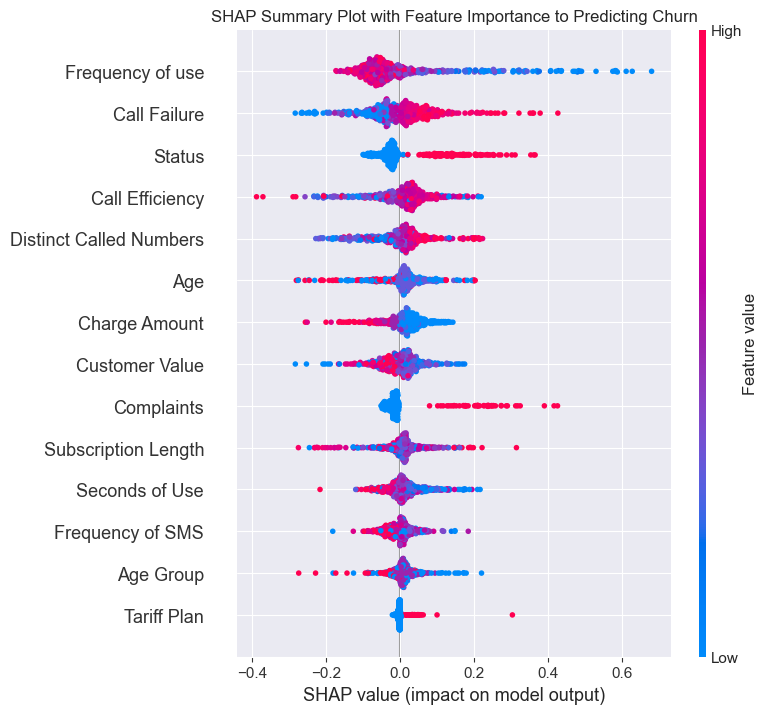

In [114]:
# Plot SHAP summary plot with feature names
shap.summary_plot(shap_values, X_test, feature_names=transformed_feature_names, show=False)
plt.title('SHAP Summary Plot with Feature Importance to Predicting Churn')
plt.show()

#### Insights:

The features are listed in descending order of their impact on the model output (from top to bottom).

1. Frequency of Use is a Key Predictor of Churn
	•	Customers with low frequency of use (blue dots) tend to contribute more positively to churn (right-side SHAP values).
	•	High-frequency users (pink dots) are less likely to churn.
	•	Insight: Encouraging engagement and usage through incentives, loyalty programs, or personalized offers can reduce churn.

2. Call Failures Negatively Impact Retention
	•	High call failures (pink) push SHAP values toward churn.
	•	Customers experiencing more failed calls are more likely to leave.
	•	Insight: Improving network reliability and addressing call failure issues can enhance retention.

3. Customer Status Matters
	•	Customer status (likely indicating active/inactive status) significantly impacts churn.
	•	Insight: Proactively identifying customers transitioning to inactive status can help implement targeted retention strategies.

4. Call Efficiency & Distinct Called Numbers Influence Churn
	•	More efficient and active communicators (high distinct called numbers and call efficiency) tend to have lower churn.
	•	Insight: Encouraging regular communication and interaction, possibly through bundled call offers, could improve retention.

5. Age & Age Group Show a Relationship with Churn
	•	Younger or older age groups may have different churn patterns.
	•	Insight: Different marketing and retention strategies should be tailored to specific age demographics.

6. Complaints are a Strong Indicator of Churn
	•	Complaints show a clear pattern affecting churn.
	•	Insight: A responsive customer support system and proactive complaint resolution can help retain customers.

7. Subscription Length and Churn
	•	Longer subscription lengths tend to reduce churn risk.
	•	Insight: Encouraging long-term subscriptions through discounts or loyalty benefits can help in customer retention.

8. Seconds of Use & Frequency of SMS
	•	Higher call duration and SMS usage correlate with lower churn.
	•	Insight: Offering plans that encourage usage (e.g free SMS promotions or unlimited calling during certain hours) could be beneficial.


*Business Actions to Reduce Churn*

	1.	Increase Engagement: Offer incentives for higher usage.
	2.	Improve Network Quality: Reduce call failures.
	3.	Proactive Customer Support: Address complaints early.
	4.	Identify High-Risk Customers: Monitor inactive or low-usage customers.
	5.	Personalized Marketing: Segment customers by age and usage behavior.
	6.	Optimize Tariff Plans: Adjust pricing or offer loyalty discounts.
	7.	Encourage Long-Term Subscriptions: Provide incentives for staying longer.


### Visualize Model Performance 

#### Confusion matrics


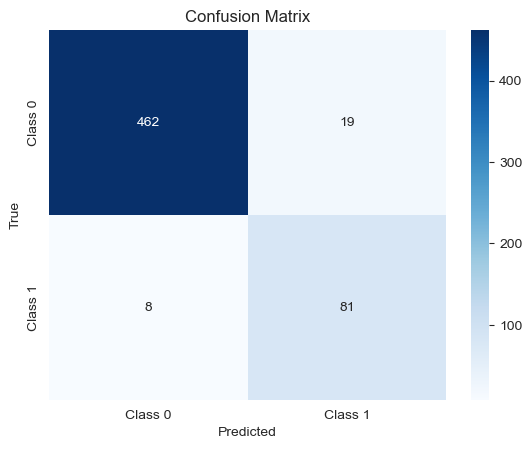

In [103]:
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

*Strengths*: The model successfully identifies most customers at risk of leaving(81/89), allowing for targeted retention efforts.

*Considerations*: It misclassifies some loyal customers (19 cases), meaning retention incentives could be given unnecessarily, but this trade off is acceptable given the high recall.

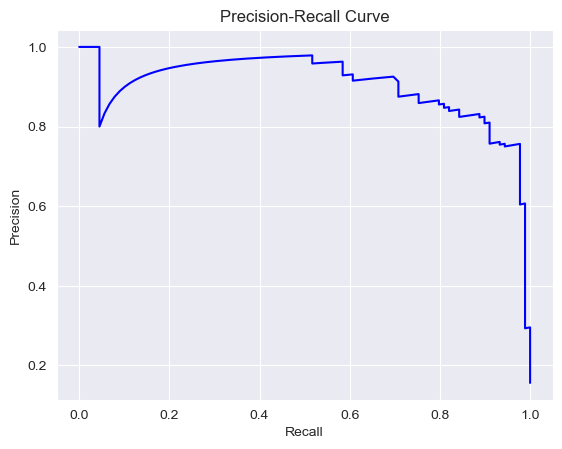

In [105]:
precision, recall, _ = precision_recall_curve(y_test, y_test_prob)
plt.plot(recall, precision, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

#### Insight :

The model maintains high precision even at high recall levels, meaning it can identify most churners while keeping false positives relatively low.

This means the  model is well calibrated for churn prediction. The businesses can trust its flagged churners and take action without excessive wasted effort on false alarms

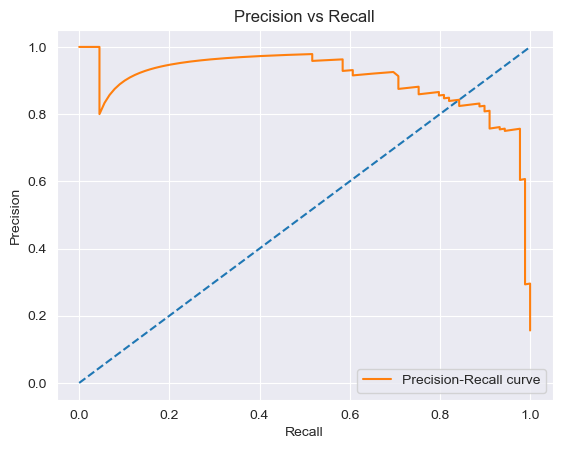

In [106]:
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs Recall')
plt.legend(loc='best')
plt.show()

#### Insight

The diagonal dashed line represents a random classifier, meaning it has no predictive power.
it would classify churn and non-churn customers purely by chance.


The model's orange precision recall curve ; is well above this line, meaning it can correctly identify churners better than random guessing